### This file is for generating actionable insights from the model outputs
- for the sake of creating an MVP im going to use the data directly from dad's store
- For the real product I will pull the data from the models and use those

In [96]:
import polars as pl
def adjust_brands(data_frame):
    """
    Renames BMW columns.
    
    This function updates 'supplier_name' to 'bmw' for all entries that contain 'bmw',
    case-insensitively.
    """
    # Ensuring case-insensitive comparison and updating 'supplier_name'
    data_frame = data_frame.with_columns(
        pl.when(
            pl.col('supplier_name').str.contains_any(["bmw"])
        ).then(pl.lit('bmw'))  # Set to 'bmw' if the condition is true
        .otherwise(pl.col('supplier_name'))  # Keep the original if the condition is false
        .alias('supplier_name')  # Ensure the column name remains 'supplier_name'
    )
    return data_frame

df_test = pl.DataFrame({
    'supplier_name': ['BMW AG', 'bmw motors', 'Mercedes-Benz', 'Audi', 'bmw', 'island bmw']
})

# Apply the function
df_test = adjust_brands(df_test)
print(df_test.columns)
print(df_test)


['supplier_name']
shape: (6, 1)
┌───────────────┐
│ supplier_name │
│ ---           │
│ str           │
╞═══════════════╡
│ BMW AG        │
│ bmw           │
│ Mercedes-Benz │
│ Audi          │
│ bmw           │
│ bmw           │
└───────────────┘


In [70]:


def convert_to_float(df, column_name):
    # First, remove spaces that might be used as thousand separators
    df = df.with_columns(
        pl.col(column_name)
        .str.replace(",", "")
        .alias("no_comma")
    )
    print("After removing spaces:", df.get_column("no_comma").to_list())

    # Then remove commas which might be used as thousand separators
    df = df.with_columns(
        pl.col("no_comma")
        .str.replace(",", "")
        .cast(pl.Float64, strict=False)
        .alias(column_name)
    )
    print("After removing commas and casting:", df.get_column(column_name).to_list())

    # Remove the intermediate 'no_spaces' column if no longer needed
    df = df.drop("no_comma")

    return df

# Example of using the function
df = pl.DataFrame({
    "price": ["10,000.00", "20 000,50", "30.000,00", "44,993750.00"]
})

df = convert_to_float(df, "price")
print(df)

After removing spaces: ['10000.00', '20 00050', '30.00000', '44993750.00']
After removing commas and casting: [10000.0, None, 30.0, 44993750.0]
shape: (4, 1)
┌────────────┐
│ price      │
│ ---        │
│ f64        │
╞════════════╡
│ 10000.0    │
│ null       │
│ 30.0       │
│ 4.499375e7 │
└────────────┘


In [537]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar

def create_long_form_dataframe(df: pl.DataFrame) -> pl.DataFrame:
    """
    Convert a wide-format DataFrame containing monthly sales data into a long-format DataFrame.
    """
    current_year = datetime.now().year
    last_year = current_year - 1
    current_month_index = datetime.now().month

    this_year_sales_columns = [f'sales_{calendar.month_abbr[i].lower()}' for i in range(1, current_month_index + 1)]
    last_year_sales_columns = [f'sales_last_{calendar.month_abbr[i].lower()}' for i in range(1, 13)]

    # Helper function to unpivot and clean data
    def unpivot_and_clean(data, columns, year):
        return (data.unpivot(
                    index=["part_number"], 
                    on=columns, 
                    variable_name='month', 
                    value_name='quantity_sold'
                )
                .with_columns([
                    pl.lit(year).alias('year'),
                    pl.col("month").str.replace("sales_", "").str.replace("last_", "").str.replace("_", "")
                ])
        )

    df_this_year = unpivot_and_clean(df, this_year_sales_columns, current_year)
    df_last_year = unpivot_and_clean(df, last_year_sales_columns, last_year)

    return pl.concat([df_this_year, df_last_year])

def calculate_rolling_sales(df, sales_columns):
    current_month_idx = datetime.now().month - 1  # Current month index (1 to 12)

    # Define ranges for 12-month and 3-month rolling sums, ensure indices are correctly mapping
    idx_12m = [(current_month_idx - i - 1) % 12 for i in range(12)]  # Circular index within a year
    idx_3m = [(current_month_idx - i - 1) % 12 for i in range(3)]

    # Adjust for the split in your sales_columns between last year and this year
    cols_12m = [sales_columns[i + 12 if i < current_month_idx else i] for i in idx_12m]
    cols_3m = [sales_columns[i + 12 if i < current_month_idx else i] for i in idx_3m]

    # Print for debugging
    print("12 Month Columns:", cols_12m)
    print("3 Month Columns:", cols_3m)

    rolling_12m_sales = pl.sum_horizontal(pl.col(cols_12m)).alias('rolling_12m_sales')
    rolling_3m_sales = pl.sum_horizontal(pl.col(cols_3m)).alias('rolling_3m_sales')

    print("Rolling 12 Month:", rolling_12m_sales)
    print("Rolling 3 Month:", rolling_3m_sales)

    # Add these as new columns to the DataFrame
    df = df.with_columns([
        rolling_12m_sales,
        rolling_3m_sales
    ])

    return df


df_wide = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')
df_long = create_long_form_dataframe(df_wide)
sales = ["sales_last_jan", "sales_last_feb", "sales_last_mar", "sales_last_apr",
        "sales_last_may", "sales_last_jun", "sales_last_jul", "sales_last_aug",
        "sales_last_sep", "sales_last_oct", "sales_last_nov", "sales_last_dec",
        "sales_jan", "sales_feb", "sales_mar","sales_apr", "sales_may", "sales_jun", 
        "sales_jul", "sales_aug", "sales_sep", "sales_oct", "sales_nov", "sales_dec"]

df = calculate_rolling_sales(df, sales)
df

12 Month Columns: ['sales_jun', 'sales_may', 'sales_apr', 'sales_mar', 'sales_feb', 'sales_jan', 'sales_last_dec', 'sales_last_nov', 'sales_last_oct', 'sales_last_sep', 'sales_last_aug', 'sales_last_jul']
3 Month Columns: ['sales_jun', 'sales_may', 'sales_apr']
Rolling 12 Month: cols(["sales_jun", "sales_may", "sales_apr", "sales_mar", "sales_feb", "sales_jan", "sales_last_dec", "sales_last_nov", "sales_last_oct", "sales_last_sep", "sales_last_aug", "sales_last_jul"]).sum_horizontal().alias("rolling_12m_sales")
Rolling 3 Month: cols(["sales_jun", "sales_may", "sales_apr"]).sum_horizontal().alias("rolling_3m_sales")


sales_sep,description,part_number,special_orders_ytd,sales_last_feb,sales_last_apr,sales_last_aug,sales_last_jan,sales_jun,price,sales_last_sep,sales_last_nov,sales_aug,supplier_name,sales_last_jul,sales_nov,sales_mar,quantity,margin,sales_last_dec,sales_feb,sales_oct,sales_last_may,quantity_ordered_ytd,sales_jul,sales_may,sales_jan,months_no_sale,sales_last_oct,sales_dec,sales_last_mar,sales_apr,sales_last_jun,negative_on_hand,rolling_12m_sales,rolling_3m_sales
i64,str,str,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,str,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,"""kit-peg,shifter,toe,chr""","""2880728-156""",0,0,0,0,0,0,129.99,0,0,0,"""polaris acceptance""",0,0,0,1,39.0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0
0,"""oil drain plug""","""11137685983""",0,0,0,0,0,0,21.99,0,0,0,"""bmw group canada""",0,0,0,1,8.55,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0
0,"""dolan,zip,hoodie,blk, s""","""msws2342-s""",0,0,0,0,0,0,124.99,0,0,0,"""triumph motorcycles""",0,0,0,1,43.75,0,0,0,0,0,0,0,0,14,0,0,1,0,0,0,0,0
0,"""pants 'rider' for men""","""76129899250""",0,0,0,0,0,0,410.99,0,0,0,"""bmw group canada""",0,0,0,1,131.94,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0
0,"""seat, rider, heated""","""t2310123""",0,0,0,0,0,0,535.99,0,0,0,"""triumph motorcycles""",0,0,0,0,187.7,1,0,0,0,0,0,0,0,18,0,0,0,0,0,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,"""circlip""","""88450441a""",0,0,0,0,0,0,0.99,0,0,0,"""ducati""",0,0,0,5,0.93,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0
0,"""gasket""","""13711342363""",0,0,0,0,0,0,7.99,0,0,0,"""bmw group canada""",0,0,0,1,3.51,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0
0,"""chrome side stand kit,""","""a9738007""",0,0,0,0,0,0,178.95,0,0,0,"""triumph motorcycles""",0,0,0,1,71.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [407]:
import polars as pl
import numpy as np

def create_seasonal_df(df):
    """
    Create a datetime column from year and month, and add cyclical features based on the datetime.

    Args:
        df (pl.DataFrame): DataFrame containing year and month columns.
        year_col (str): Column name with the year.
        month_col (str): Column name with the month name.

    Returns:
        pl.DataFrame: Enhanced DataFrame with datetime and cyclical features.
    """
    # Map month names to numbers (if needed)
    month_to_number = {month.lower(): i for i, month in enumerate(calendar.month_abbr) if month}

    # Create a datetime column assuming the first day of each month
    month_number_expr = pl.when(pl.col("month").str.to_lowercase() == "jan").then(1)
    for month, num in month_to_number.items():
        month_number_expr = month_number_expr.when(pl.col("month").str.to_lowercase() == month).then(num)

    # Apply the case expression
    df = df.with_columns(month_number_expr.alias("month_number"))

    month_numbers = df.get_column("month_number").to_numpy()  # Convert to numpy array for calculations
    month_sin = np.sin(2 * np.pi * month_numbers / 12)
    month_cos = np.cos(2 * np.pi * month_numbers / 12)

    # Add calculated columns back to DataFrame
    df = df.with_columns([
        pl.Series("month_sin", month_sin),
        pl.Series("month_cos", month_cos)
    ])

    print(f"Shape after adding cyclical features: {df.shape}")
    print(f"DataFrame with cyclical features: {df.head()}")
    
    return df

def create_seasonal_component(df, window_size=12):
    """
    Enhance a DataFrame with a rolling average and combine it with cyclical features to create a seasonal component.

    Args:
        df (pl.DataFrame): DataFrame with columns for part number, date, quantity sold, and cyclical features.
        window_size (int): Size of the rolling window for calculating the moving average.

    Returns:
        pl.DataFrame: DataFrame with added rolling average and seasonal adjustment features.
    """
    # Calculate the rolling mean for the quantity sold
    df = df.with_columns(
        pl.col("quantity_sold").rolling_mean(window_size=window_size, min_periods=1).alias("rolling_avg")
    )

    # Calculate deviation from the rolling average
    df = df.with_columns(
        (pl.col("quantity_sold") - pl.col("rolling_avg")).alias("deviation")
    )

    # Combine cyclical features with deviations to create a seasonal score
    df = df.with_columns(
        (pl.col("deviation") * pl.col("month_sin") + pl.col("deviation") * pl.col("month_cos")).alias("seasonal_score")
    )

    # You could also normalize this score by the number of observations (i.e., months) for each part number
    df = df.group_by("part_number").agg([
        pl.mean("seasonal_score").alias("normalized_seasonal_score")
    ])

    return df


# Assuming df is already defined
df_processed = create_seasonal_df(df)
seasonal_df = create_seasonal_component(df_processed)

df_wide = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')
final_df = df_wide.join(seasonal_df, on=pl.col('part_number'), how='left')
final_df

Shape after adding cyclical features: (335426, 7)
DataFrame with cyclical features: shape: (5, 7)
┌─────────────────┬───────┬───────────────┬──────┬──────────────┬───────────┬───────────┐
│ part_number     ┆ month ┆ quantity_sold ┆ year ┆ month_number ┆ month_sin ┆ month_cos │
│ ---             ┆ ---   ┆ ---           ┆ ---  ┆ ---          ┆ ---       ┆ ---       │
│ str             ┆ str   ┆ i64           ┆ i32  ┆ i32          ┆ f64       ┆ f64       │
╞═════════════════╪═══════╪═══════════════╪══════╪══════════════╪═══════════╪═══════════╡
│ 46637652855     ┆ jan   ┆ 0             ┆ 2024 ┆ 1            ┆ 0.5       ┆ 0.866025  │
│ 987703386       ┆ jan   ┆ 0             ┆ 2024 ┆ 1            ┆ 0.5       ┆ 0.866025  │
│ 99-049          ┆ jan   ┆ 0             ┆ 2024 ┆ 1            ┆ 0.5       ┆ 0.866025  │
│ 99991-pitbx-k2s ┆ jan   ┆ 0             ┆ 2024 ┆ 1            ┆ 0.5       ┆ 0.866025  │
│ 353-0589        ┆ jan   ┆ 0             ┆ 2024 ┆ 1            ┆ 0.5       ┆ 0.866025  │
└─

months_no_sale,sales_sep,sales_last_jan,special_orders_ytd,sales_last_feb,quantity,sales_last_mar,sales_feb,sales_last_oct,sales_last_sep,sales_mar,sales_apr,sales_last_jul,description,sales_last_jun,margin,quantity_ordered_ytd,sales_nov,price,supplier_name,sales_dec,part_number,sales_last_may,sales_last_aug,sales_last_dec,sales_jun,sales_oct,sales_last_nov,sales_jan,sales_last_apr,sales_may,sales_aug,sales_jul,negative_on_hand,normalized_seasonal_score
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,f64,i64,i64,f64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
18,0,0,0,0,1,0,0,0,0,0,0,0,"""supporting plate left""",0,5.01,0,0,15.99,"""bmw group canada""",0,"""46637652855""",0,0,0,0,0,0,0,0,0,0,0,0,0.005991
9,0,0,0,0,2,0,0,0,0,0,0,0,"""sweatshirt logo roundneck""",0,40.02,0,0,99.99,"""ducati""",0,"""987703386""",0,0,0,0,0,0,0,0,0,0,0,0,0.005991
0,0,0,0,0,3,0,0,0,0,0,0,0,"""tube 225/250-16""",0,3.45,0,0,7.99,"""motovan""",0,"""99-049""",1,0,0,0,0,0,0,0,0,0,0,0,-0.010062
0,0,0,0,1,0,0,1,0,0,0,0,0,"""pit kit 2 synthetic""",0,16.0,0,0,47.99,"""suzuki""",0,"""99991-pitbx-k2s""",0,0,0,0,0,0,0,0,0,0,0,0,0.141012
0,0,8,6,0,0,1,0,0,0,6,0,8,"""shock fluid light 75/390, 3wt""",33,270.64,0,0,507.99,"""motovan""",0,"""353-0589""",14,10,0,0,0,0,0,2,3,0,0,0,-2.181101
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
12,0,0,0,0,2,0,0,0,0,0,0,0,"""high front mudguard""",0,99.75,0,0,284.99,"""triumph motorcycles""",0,"""a9701423""",0,0,0,0,0,0,0,0,0,0,0,0,-0.035948
8,0,0,0,0,1,0,0,0,0,0,0,0,"""oil drain plug""",0,12.71,0,0,33.99,"""bmw group canada""",0,"""11138359126""",0,0,0,0,0,0,0,0,0,0,0,0,-0.034343
18,0,0,0,0,1,0,0,0,0,0,0,0,"""wave washer""",0,1.35,0,0,2.99,"""bmw group canada""",0,"""7119932030""",0,0,0,0,0,0,0,0,0,0,0,0,-0.028351


In [507]:
print('Calculating current month sales for 30 days supply...')
df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')
current_month = datetime.now().month - 1
month_abbr = calendar.month_abbr[current_month].lower()
this_month_sales_column = f'sales_{month_abbr}'

this_month_sales_sum = df.select([
        pl.col(this_month_sales_column).sum().alias('total_sales_current_month')
    ])
print(this_month_sales_sum.item())

Calculating current month sales for 30 days supply...
2409


In [390]:
df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/Data/Processed/parts_data_cleaned.csv')

def fun_funct(df):

    current_month =  datetime.now().month
    this_year_sales_columns = [f'sales_{calendar.month_abbr[i].lower()}' for i in range(1, current_month + 1)]

    df = df.with_columns(
            (pl.col('price') - pl.col('margin')).round(2).alias('cost_per_unit')
        )
    df.with_columns(
        (pl.col('cost_per_unit') * pl.col('quantity')).round(2).alias('total_cost')
    )
    total_sales_ytd = pl.sum_horizontal(this_year_sales_columns).alias('total_sales_ytd')

    df = df.with_columns(total_sales_ytd)

    df = df.with_columns([
        (pl.col('total_sales_ytd') * pl.col('price')).round(2).alias('sales_revenue'),
        (pl.col('total_sales_ytd') * pl.col('cost_per_unit')).round(2).alias('cogs')
    ])

    # Calculate 'gross_profit'
    df = df.with_columns([
        (pl.col('sales_revenue') - pl.col('cogs')).round(2).alias('gross_profit')
    ])

    # Calculate 'roi'
    df = df.with_columns([
        pl.when(pl.col('cogs') > 0)
        .then((pl.col('gross_profit') / pl.col('cogs')) * 100)
        .otherwise(0.00)
        .round(2)
        .alias('roi')
    ])

    return df


df_n = fun_funct(df)
df_n

part_number,sales_last_jan,sales_last_feb,sales_last_mar,sales_last_apr,sales_last_may,sales_last_jun,sales_last_jul,sales_last_aug,sales_last_sep,sales_last_oct,sales_last_nov,sales_last_dec,sales_jan,sales_feb,sales_mar,sales_apr,sales_may,sales_jun,sales_jul,sales_aug,sales_sep,sales_oct,sales_nov,sales_dec,quantity,quantity_ordered_ytd,special_orders_ytd,description,margin,price,supplier_name,months_no_sale,negative_on_hand,cost_per_unit,total_sales_ytd,sales_revenue,cogs,gross_profit,roi
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,str,i64,i64,f64,i64,f64,f64,f64,f64
"""286065606""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"""mw montana waxed jkt-l""",348.74,464.99,"""polaris acceptance""",18,0,116.25,1,464.99,116.25,348.74,299.99
"""5262804-01""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""console-inner,pat3202m""",49.7,141.99,"""polaris acceptance""",32,0,92.29,0,0.0,0.0,0.0,0.0
"""56410711a""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""guard, flap""",67.8,224.99,"""ducati""",19,0,157.19,0,0.0,0.0,0.0,0.0
"""0316-0349""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,"""110/80r19 59v road 5 trail fro""",235.05,411.99,"""parts canada/power twins""",18,0,176.94,1,411.99,176.94,235.05,132.84
"""555-06474""",0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""wfx3 wp black l""",36.02,119.99,"""motovan""",17,0,83.97,0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""34117651954""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"""set of mounting parts, left""",14.75,43.99,"""bmw group canada""",19,0,29.24,0,0.0,0.0,0.0,0.0
"""23008569917""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,"""chain pinion""",53.79,110.99,"""bmw group canada""",19,0,57.2,0,0.0,0.0,0.0,0.0
"""t3600112""",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""seal ,countershaft 40 62 6""",6.27,16.99,"""triumph motorcycles""",18,0,10.72,0,0.0,0.0,0.0,0.0


In [163]:
number_of_dealerships_na = 35000 + 4000
number_of_wholesalers_na = 157000 + 11000
number_of_dealerships_global = 1913948  # Global
number_of_wholesalers_global = 10000000  # Global
global_customers = number_of_wholesalers_global + number_of_dealerships_global 
na_customers = number_of_wholesalers_na + number_of_dealerships_na

value_of_inventory = 450000  # Value per dealership
percentage_inventory_obsolete = 0.2
price_discount = 0.5
percentage_obsolescence_cleared = 0.75 # 66.7% clearance rate
dealer_commission_rate = 0.075
surplus_commission_rate = 0.125

# Calculate the cleared value of obsolescence
cleared_obsolescence_value = value_of_inventory * percentage_inventory_obsolete * percentage_obsolescence_cleared * price_discount

# Allocate the cleared value
average_surplus_transaction_value = 15000  # Higher average transaction value for surplus
average_wholesale_transaction_value = 275  # Higher average for wholesale
average_d2d_transaction_value = 150  # Higher average for D2D

monthly_surplus_transactions = 1
monthly_wholesale_transactions = 12.5  
monthly_d2d_transactions = 9.5  

# Calculate total transaction revenue using higher values and frequencies
total_surplus_revenue = monthly_surplus_transactions * average_surplus_transaction_value * 3 * surplus_commission_rate
total_wholesale_revenue = monthly_wholesale_transactions * average_wholesale_transaction_value * 12 * dealer_commission_rate
total_d2d_revenue = monthly_d2d_transactions * average_d2d_transaction_value * 12 * dealer_commission_rate


dealership_subscription = 499.99


# Total revenue from obsolescence
total_revenue_obsolescence = total_surplus_revenue + total_wholesale_revenue + total_d2d_revenue

global_revenue_commisions = total_revenue_obsolescence * global_customers 
global_subscription = number_of_dealerships_global * dealership_subscription

na_revenue_commission = total_revenue_obsolescence * na_customers
na_subscription = number_of_dealerships_na * dealership_subscription

number_dealers = 3300
number_wholesalers = 12500

TAM = global_revenue_commisions + global_subscription
SAM = na_revenue_commission + na_subscription
SOM = (total_revenue_obsolescence * (number_dealers + number_wholesalers)) + (dealership_subscription * number_dealers)


# Print results
print(f'Value of obsolescence cleared per dealership: ${cleared_obsolescence_value:,.2f}')
print(f'Revenue from Surplus Buyer: ${total_surplus_revenue:,.2f}')
print(f'Revenue from Wholesale: ${total_wholesale_revenue:,.2f}')
print(f'Revenue from D2D: ${total_d2d_revenue:,.2f}')
print(f'Total Commision Revenue Per dealership: ${total_revenue_obsolescence:,.2f}')
print(f'Total Subscription Revenue Per Dealership: ${(dealership_subscription * 12):,.2f}')
print(f'Total Reveue Per Dealer: {((dealership_subscription * 12) + total_revenue_obsolescence):,.2f}')
print('---------------------------------------------------------')
print(f'Total Addressable Market(TAM): ${TAM:,.2f}')
print(f'Servicable Addressable Market(SAM): ${SAM:,.2f}')
print(f'Servicable Obstainable Market(SOM): ${SOM:,.2f}')
print('---------------------------------------------------------')
print(f'% of Dealer customers: {number_dealers/number_of_dealerships_na * 100}%')
print(f'% of Wholesale customers: {number_wholesalers/number_of_wholesalers_na * 100}%')
print('---------------------------------------------------------')
print(f'Dealers to reach 100M ARR: {100000000 / (499.99 * 12) :,.0f}')
print(f'Percentage of Global Market: {(16667/number_of_dealerships_global) * 100:.2f}%')
print('---------------------------------------------------------')
print(f'Opportunity Cost of Capital: ${(value_of_inventory*0.15*0.5 * number_of_dealerships_global) * 0.4 * 8:,.2f}')


Value of obsolescence cleared per dealership: $33,750.00
Revenue from Surplus Buyer: $5,625.00
Revenue from Wholesale: $3,093.75
Revenue from D2D: $1,282.50
Total Commision Revenue Per dealership: $10,001.25
Total Subscription Revenue Per Dealership: $5,999.88
Total Reveue Per Dealer: 16,001.13
---------------------------------------------------------
Total Addressable Market(TAM): $120,111,327,295.52
Servicable Addressable Market(SAM): $2,089,758,360.00
Servicable Obstainable Market(SOM): $159,669,717.00
---------------------------------------------------------
% of Dealer customers: 8.461538461538462%
% of Wholesale customers: 7.440476190476191%
---------------------------------------------------------
Dealers to reach 100M ARR: 16,667
Percentage of Global Market: 0.87%
---------------------------------------------------------
Opportunity Cost of Capital: $206,706,384,000.00


In [172]:
print(f'${1500000 * value_of_inventory * 1.25 * 0.1:,.2f}')

$84,375,000,000.00


shape: (337_459, 8)
┌─────────────┬───────┬───────────────┬──────┬───────────┬──────────────┬────────────┬────────────┐
│ part_number ┆ month ┆ quantity_sold ┆ year ┆ month_str ┆ month_number ┆ year_month ┆ 6_month_MA │
│ ---         ┆ ---   ┆ ---           ┆ ---  ┆ ---       ┆ ---          ┆ ---        ┆ ---        │
│ str         ┆ str   ┆ i64           ┆ i32  ┆ str       ┆ i64          ┆ i64        ┆ f64        │
╞═════════════╪═══════╪═══════════════╪══════╪═══════════╪══════════════╪════════════╪════════════╡
│ 286065606   ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301     ┆ 0.0        │
│ 5262804-01  ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301     ┆ 0.0        │
│ 56410711a   ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301     ┆ 0.0        │
│ 0316-0349   ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301     ┆ 0.0        │
│ 555-06474   ┆ jan   ┆ 0             ┆ 2023 ┆ jan       ┆ 1            ┆ 202301

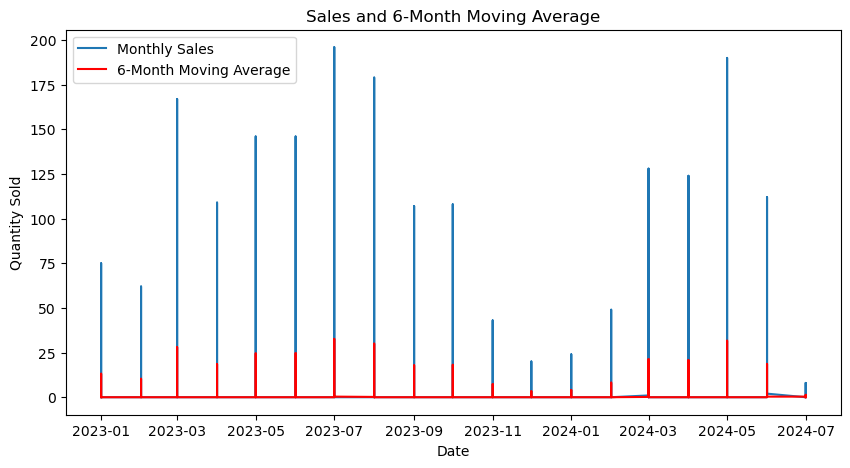

In [171]:
import pandas as pd
month_to_number = {month.lower(): i for i, month in enumerate(calendar.month_abbr[1:], start=1)}

# Create a helper DataFrame from the dictionary
month_mapping_df = pl.DataFrame({
    "month_str": list(month_to_number.keys()),
    "month_number": list(month_to_number.values())
})

# Join the DataFrame with the month mapping
df = df.join(month_mapping_df, left_on=pl.col("month").str.to_lowercase(), right_on="month_str")

# Create a combined year_month column that is sortable
df = df.with_columns(
    (pl.col("year") * 100 + pl.col("month_number")).alias("year_month")
).sort("year_month")

# Calculate the 6-month moving average for 'quantity_sold'
df = df.with_columns(
    pl.col("quantity_sold").rolling_mean(window_size=6, min_periods=1).alias("6_month_MA")
)

# Optionally, display the DataFrame to check results
print(df)

# Convert to Pandas for plotting (optional)
pdf = df.to_pandas()

# Convert 'year_month' into a proper date format for plotting
pdf['Date'] = pd.to_datetime(pdf['year_month'].astype(str), format='%Y%m')

plt.figure(figsize=(10, 5))
plt.plot(pdf['Date'], pdf['quantity_sold'], label='Monthly Sales')
plt.plot(pdf['Date'], pdf['6_month_MA'], label='6-Month Moving Average', color='red')
plt.title('Sales and 6-Month Moving Average')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

In [201]:
import polars as pl
from datetime import datetime
import calendar

def get_month_number_expr(month_col):
    month_to_number = {month.lower(): i for i, month in enumerate(calendar.month_abbr) if month}
    
    month_number_expr = pl.when(pl.col(month_col).str.to_lowercase() == "jan").then(1)
    for month, num in month_to_number.items():
        month_number_expr = month_number_expr.when(pl.col(month_col).str.to_lowercase() == month).then(num)
    
    return month_number_expr.otherwise(pl.lit(None))

def get_last_day_of_month(year, month):
    return calendar.monthrange(year, month)[1]

def create_long_form_dataframe(df: pl.DataFrame) -> pl.DataFrame:
    """
    Convert a wide-format DataFrame containing monthly sales data into a long-format DataFrame.
    """
    current_year = datetime.now().year
    last_year = current_year - 1
    current_month_index = datetime.now().month

    this_year_sales_columns = [f'sales_{calendar.month_abbr[i].lower()}' for i in range(1, current_month_index + 1)]
    last_year_sales_columns = [f'sales_last_{calendar.month_abbr[i].lower()}' for i in range(1, 13)]

    # Helper function to unpivot and clean data
    def unpivot_and_clean(data, columns, year):
        unpivoted_data = (data.unpivot(
                    index=["part_number"], 
                    on=columns, 
                    variable_name='month', 
                    value_name='quantity_sold'
                )
        )

        unpivoted_data = unpivoted_data.with_columns([
            pl.lit(year).alias('year'),
            pl.col("month").str.replace("sales_", "").str.replace("last_", "").str.replace("_", "").alias('clean_month')
        ])

        # Get the month number
        month_number_expr = get_month_number_expr("clean_month")
        unpivoted_data = unpivoted_data.with_columns(month_number_expr.alias("month_number"))

        # Calculate the last day of each month
        last_day_expr = pl.struct(["year", "month_number"]).map_elements(
            lambda row: get_last_day_of_month(row['year'], row['month_number']), return_dtype=pl.Int32
        ).alias("day")

        unpivoted_data = unpivoted_data.with_columns(last_day_expr)

        # Create a new column with the end of month dates
        unpivoted_data = unpivoted_data.with_columns(
            pl.datetime(
                year=pl.col("year"),
                month=pl.col("month_number"),
                day=pl.col("day")
            ).alias("date")
        )
        return unpivoted_data.drop(["clean_month"])

    # Unpivot and clean the data for this year and last year
    df_this_year = unpivot_and_clean(df, this_year_sales_columns, current_year)
    df_last_year = unpivot_and_clean(df, last_year_sales_columns, last_year)

    # Combine the dataframes
    df_long = pl.concat([df_this_year, df_last_year])

    return df_long

# Example usage
df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/parts_data_prepared.csv')
df_long = create_long_form_dataframe(df)
print(df_long)



shape: (331_949, 7)
┌─────────────┬────────────────┬───────────────┬──────┬──────────────┬─────┬─────────────────────┐
│ part_number ┆ month          ┆ quantity_sold ┆ year ┆ month_number ┆ day ┆ date                │
│ ---         ┆ ---            ┆ ---           ┆ ---  ┆ ---          ┆ --- ┆ ---                 │
│ str         ┆ str            ┆ i64           ┆ i32  ┆ i32          ┆ i32 ┆ datetime[μs]        │
╞═════════════╪════════════════╪═══════════════╪══════╪══════════════╪═════╪═════════════════════╡
│ 13317687263 ┆ sales_jan      ┆ 0             ┆ 2024 ┆ 1            ┆ 31  ┆ 2024-01-31 00:00:00 │
│ 76411331a   ┆ sales_jan      ┆ 0             ┆ 2024 ┆ 1            ┆ 31  ┆ 2024-01-31 00:00:00 │
│ 71607711241 ┆ sales_jan      ┆ 0             ┆ 2024 ┆ 1            ┆ 31  ┆ 2024-01-31 00:00:00 │
│ 5416660     ┆ sales_jan      ┆ 0             ┆ 2024 ┆ 1            ┆ 31  ┆ 2024-01-31 00:00:00 │
│ 4261124     ┆ sales_jan      ┆ 0             ┆ 2024 ┆ 1            ┆ 31  ┆ 2024-01-31 0

In [204]:
def calculate_rolling_sales(df_long, df_original):
    """
    Calculate rolling sales, aggregate them, and join the results back to the original DataFrame.

    Args:
        df_long (pl.DataFrame): DataFrame in long format with 'part_number', 'date', and 'quantity_sold'.
        df_original (pl.DataFrame): Original DataFrame before conversion to long format.

    Returns:
        pl.DataFrame: Original DataFrame enriched with aggregated rolling sales data.
    """
    # Ensure the data is sorted by part_number and date
    df_long = df_long.sort(by=["part_number", "date"])

    # Calculate rolling sales
    df_rolling = df_long.with_columns([
        pl.col("quantity_sold").rolling_sum(window_size=3, min_periods=1).over("part_number").alias("rolling_3m_sales"),
        pl.col("quantity_sold").rolling_sum(window_size=12, min_periods=1).over("part_number").alias("rolling_12m_sales")
    ])

    # Aggregate rolling sales over all months for each part number
    df_aggregated = df_rolling.group_by("part_number").agg([
        pl.col("rolling_3m_sales").last().alias("rolling_3m_sales"),
        pl.col("rolling_12m_sales").last().alias("rolling_12m_sales")
    ])

    # Join the aggregated data back to the original DataFrame
    df_enriched = df_original.join(df_aggregated, on="part_number", how="left")

    return df_enriched

fdf = calculate_rolling_sales(df_long, df)
fdf

part_number,normalized_seasonal_score,quantity,sales_last_mar,sales_last_feb,sales_sep,sales_last_jun,price,sales_last_jan,sales_last_jul,sales_last_sep,supplier_name,sales_last_nov,sales_feb,sales_jul,sales_last_may,sales_jun,special_orders_ytd,months_no_sale,sales_dec,quantity_ordered_ytd,margin,sales_last_apr,sales_last_dec,sales_nov,sales_may,description,sales_mar,sales_apr,sales_last_oct,sales_last_aug,sales_oct,sales_jan,sales_aug,negative_on_hand,cost_per_unit,total_cost,margin_percentage,sales_revenue,cogs,gross_profit,roi,rolling_3m_sales,rolling_12m_sales,12m_days_supply,3m_days_supply,1m_days_supply,turnover,3m_turnover,sell_through_rate,days_of_inventory_outstanding,order_to_sales_ratio,rolling_3m_sales_right,rolling_12m_sales_right
str,f64,i64,i64,i64,i64,i64,f64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,f64,f64,f64,i64,f64,i64,i64
"""13317687263""",0.038298,5,0,0,0,0,74.99,0,0,0,"""bmw group canada""",0,0,0,0,0,0,19,0,0,30.29,0,0,0,0,"""fuel hose""",0,0,0,0,0,0,0,0,44.7,223.5,40.39,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,570,0.0,0,0
"""76411331a""",-0.014333,1,0,0,0,0,3.99,0,0,0,"""ducati""",0,0,0,0,0,0,56,0,0,2.37,0,0,0,0,"""rubber pad""",0,0,0,0,0,0,0,0,1.62,1.62,59.4,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,1680,0.0,0,0
"""71607711241""",-0.091161,1,0,0,0,0,26.99,0,2,0,"""bmw group canada""",0,0,0,0,0,0,18,0,0,9.78,0,0,0,0,"""retaining tab, rear""",0,0,0,0,0,0,0,0,17.21,17.21,36.24,0.0,0.0,0.0,0.0,6,24,15,15,0,0.0,0.0,2400.0,540,0.0,0,0
"""5416660""",0.001605,1,0,0,0,0,49.99,0,0,0,"""polaris acceptance""",0,0,0,0,0,0,19,0,0,24.99,0,0,0,0,"""hose-rad,out""",0,0,0,0,0,0,0,0,25.0,25.0,49.99,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,570,0.0,0,0
"""4261124""",-0.061519,0,0,0,0,0,285.99,0,0,0,"""thibault canada""",0,0,0,0,0,0,18,0,0,168.51,0,0,0,0,"""110/80zr18 tl (58w) angel gt f""",0,0,0,1,0,0,0,0,117.48,0.0,58.92,0.0,0.0,0.0,0.0,3,12,0,0,0,0.0,0.0,0.0,540,0.0,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""6230582""",-0.013473,0,0,0,0,0,64.99,0,0,0,"""polaris acceptance""",1,0,0,0,0,0,18,0,0,26.0,0,0,0,0,"""shaft-clutch lifter""",0,0,0,0,0,0,0,0,38.99,0.0,40.01,0.0,0.0,0.0,0.0,3,9,0,0,0,0.0,0.0,0.0,540,0.0,0,1
"""t1130295""",0.025571,8,0,0,0,0,12.99,0,0,0,"""triumph motorcycles""",0,0,0,0,0,0,19,0,0,5.22,0,0,0,0,"""shim tappet 2.95""",0,0,0,0,0,0,0,0,7.77,62.16,40.18,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,570,0.0,0,0
"""51422-l""",-0.007167,0,0,0,0,0,29.99,0,0,0,"""fundy textile and design ltd""",0,0,0,0,0,0,19,0,0,14.77,0,0,0,0,"""black,ladies,indian,script-lg""",0,0,0,0,0,0,0,1,15.22,0.0,49.25,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,570,0.0,0,0


In [86]:
import pandas as pd
df = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/Data/Output/parts_data.feather")

# "what brand has the least total obsolete parts out of my top 5 brands with the highest gross profit?"


mask = df['inventory_category'] == 'obsolete'
qdf = df[mask].groupby('supplier_name')['quantity'].sum().sort_values()

# Calculating total gross profit per supplier
gpdf = df.groupby('supplier_name')['gross_profit'].sum().sort_values(ascending=False)

# Merging the two dataframes
fdf = pd.merge(gpdf, qdf, on='supplier_name', how='left').reset_index()

# Filter for top 5 brands by gross profit
top_5_gross_profit = fdf.nlargest(5, 'gross_profit')

# Sorting the top 5 by quantity of obsolete parts
result = top_5_gross_profit.sort_values(by='quantity', ascending=True)
result

,supplier_name,gross_profit,quantity
4,kimpex,25164.16,272.0
1,parts canada/power twins,57019.86,595.0
3,triumph motorcycles,27687.13,1418.0
2,polaris acceptance,39340.29,2808.0
0,bmw group canada,89368.96,10317.0


In [11]:
df = pd.read_feather("/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/output_data/parts_data.feather")
mask = df['inventory_category'] == 'obsolete'
gm = df[~mask][['part_number', 'description', 'supplier_name', 'roi']]

# Group by supplier_name and calculate the average margin_percentage
grouped_gm = gm.groupby('supplier_name')['roi'].mean().reset_index()

# Sort by margin_percentage in descending order
grouped_gm_sorted = grouped_gm.sort_values(by='roi', ascending=False)

# Display the result
print(grouped_gm_sorted)

                   supplier_name         roi
4               bumper to bumper  670.730000
8        earthtrack supply group  419.920000
7                         ducati  318.193846
17                        lordco  198.443333
19                          moto  176.430000
18                       mavrick  176.190000
22      parts canada/power twins  149.251872
16                        kimpex   75.347229
20                       motovan   49.099219
11                     full bore    7.357500
0    action motorcycles / barnes    0.000000
28                       triumph   -7.776788
12  fundy textile and design ltd  -15.825000
25                     schuberth  -19.770000
23            polaris acceptance  -20.268584
27               thibault canada  -22.756410
3               bmw group canada  -23.011650
32              zero motorcycles  -25.000000
29           triumph motorcycles  -32.431729
26                  shell canada  -45.715000
2                bell sports inc  -48.235000
13        

In [119]:
import polars as pl
df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/parts_data_prepared.csv')

sales_columns = ["sales_last_jan", "sales_last_feb", "sales_last_mar", "sales_last_apr",
                 "sales_last_may", "sales_last_jun", "sales_last_jul", "sales_last_aug",
                 "sales_last_sep", "sales_last_oct", "sales_last_nov", "sales_last_dec",
                 "sales_jan", "sales_feb", "sales_mar", "sales_apr", "sales_may", "sales_jun",
                 "sales_jul"]

# Select specific columns from the DataFrame
ndf = df.select(["part_number"] + ["description"] + ["quantity"] + ['price'] + sales_columns + ["months_no_sale"])

ndf.write_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/monthly_parts_data.csv')


In [ ]:
#Robust anonymization of part number and brand to add an additional layer of data privacy
import hashlib
import uuid
class DataAnonymizer:
    def __init__(self):
        self.mapping_table = {}

    def generate_salt(self):
        return uuid.uuid4().hex

    def hash_value(self, value, salt):
        return hashlib.sha256((salt + value).encode()).hexdigest()

    def anonymize_field(self, value, dealership_id):
        salt = self.mapping_table.get(dealership_id, {}).get('salt')
        if not salt:
            salt = self.generate_salt()
            if dealership_id not in self.mapping_table:
                self.mapping_table[dealership_id] = {'salt': salt}
        hashed_value = self.hash_value(value, salt)
        self.mapping_table[dealership_id][hashed_value] = value
        return hashed_value

    def de_anonymize_field(self, hashed_value, dealership_id):
        return self.mapping_table.get(dealership_id, {}).get(hashed_value)
    

anonymizer = DataAnonymizer()
dealership_id = 'Island Motorcycle Company'
part_number = 'ABC123'
brand = 'BrandX'

hashed_dealership = anonymizer.anonymize_field(dealership_id, dealership_id)
hashed_part_number = anonymizer.anonymize_field(part_number, dealership_id)
hashed_brand = anonymizer.anonymize_field(brand, dealership_id)

print(f'Anonymized Dealership: {hashed_dealership}')
print(f"Anonymized Part Number: {hashed_part_number}")
print(f"Anonymized Brand: {hashed_brand}")

original_part_number = anonymizer.de_anonymize_field(hashed_part_number, dealership_id)
original_brand = anonymizer.de_anonymize_field(hashed_brand, dealership_id)

print(f"Dealership: {dealership_id}")
print(f"Original Part Number: {original_part_number}")
print(f"Original Brand: {original_brand}")

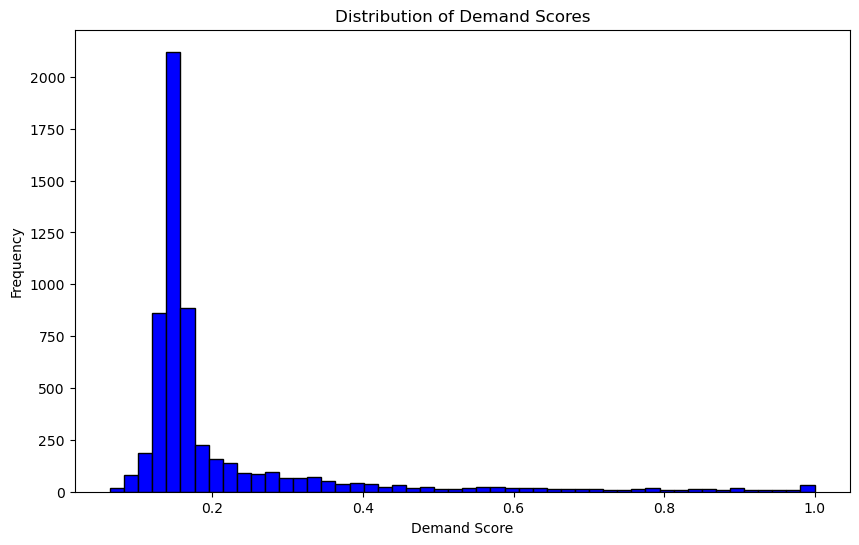

In [17]:
import polars as pl
import matplotlib.pyplot as plt
def visualize_demand_distribution(demand_scores):
    # Plotting the distribution of demand scores
    plt.figure(figsize=(10, 6))
    plt.hist(demand_scores, bins=50, color='blue', edgecolor='black')
    plt.title('Distribution of Demand Scores')
    plt.xlabel('Demand Score')
    plt.ylabel('Frequency')
    plt.show()

df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/processed_data_with_demand_score.csv')
df = df.filter(pl.col('demand') > 0)

demand_score = df.select(pl.col('demand')).to_numpy()

visualize_demand_distribution(demand_score)


In [36]:
df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/processed_data_final.csv')
df

part_number,part_status,safety_stock,reorder_point,price,days_of_inventory_outstanding,order_to_sales_ratio,description,months_no_sale,sales_last_jun,sales_last_dec,quantity,normalized_seasonal_score,sales_mar,sales_apr,sales_oct,sales_nov,sales_last_feb,sales_revenue,sales_jun,roi,sales_feb,sales_last_may,rolling_12m_sales,sales_volatility,demand,negative_on_hand,sales_last_aug,sales_sep,cogs,sales_last_oct,sales_dec,total_cost,rolling_3m_sales,turnover,sales_last_jul,sales_last_sep,sales_trend,sales_last_jan,3m_days_supply,sales_may,12m_days_supply,special_orders_ytd,1m_days_supply,recent_sales_trend,3m_turnover,sales_jul,sales_aug,margin_percentage,quantity_ordered_ytd,sales_last_mar,cost_per_unit,gross_profit,supplier_name,sales_last_nov,sales_jan,sales_last_apr,margin,sell_through_rate,obsolescence_risk
str,str,i64,i64,f64,i64,f64,str,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,i64,f64,f64,i64,i64,i64,f64,i64,i64,f64,i64,f64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,f64,f64,str,i64,i64,i64,f64,f64,f64
"""16510-35g00""","""obsolete""",0,0,10.99,570,0.0,"""filter""",19,0,0,2,0.014763,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,14.36,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,34.67,0,0,7.18,0.0,"""suzuki""",0,0,0,3.81,0.0,1.0
"""7129903041""","""obsolete""",0,0,6.99,570,0.0,"""fillister head with washer""",19,0,0,2,0.016369,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,8.28,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,40.77,0,0,4.14,0.0,"""bmw group canada""",0,0,0,2.85,0.0,1.0
"""2503-0366""","""idle""",0,0,32.99,570,0.0,"""balaclava light bk""",2,0,0,2,-0.083679,0,0,0,0,0,65.98,0,54.01,0,0,2,4.358899,0.122372,0,0,0,42.84,0,0,42.84,2,0.639594,0,0,0.024561,0,90,2,365,0,0,-1.0,1.22435,0,0,35.07,0,0,21.42,23.14,"""parts canada/power twins""",0,0,0,11.57,50.0,0.017343
"""46638533674""","""obsolete""",0,0,24.99,570,0.0,"""bearing for windshield adjus""",19,0,0,4,-0.001605,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,63.36,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,36.61,0,0,15.84,0.0,"""bmw group canada""",0,0,0,9.15,0.0,1.0
"""t2501680""","""idle""",0,0,120.99,1534,0.0,"""yt7b-bs, 6.5a/h, 85cca""",1,0,0,7,-0.076482,0,0,0,0,0,241.98,1,67.23,0,0,3,2.372684,0.204403,0,0,0,144.7,0,0,506.45,2,0.237817,0,1,0.024561,0,315,1,851,0,0,-0.5,1.130557,0,0,40.2,0,0,72.35,97.28,"""triumph motorcycles""",0,0,0,48.64,30.0,0.01758
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""t1310310""","""obsolete""",0,0,3.99,2100,0.0,"""o-ring""",70,0,0,2,0.007167,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,3.96,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,50.38,0,0,1.98,0.0,"""triumph motorcycles""",0,0,0,2.01,0.0,1.0
"""7119901398""","""obsolete""",0,0,22.99,570,0.0,"""o-ring""",19,0,0,1,0.013158,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,14.4,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,37.36,0,0,14.4,0.0,"""bmw group canada""",0,0,0,8.59,0.0,1.0
"""2884992""","""obsolete""",0,0,144.99,570,0.0,"""k-center console bag,slg,us""",19,0,0,1,0.009947,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,101.49,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,30.0,0,0,101.49,0.0,"""polaris acceptance""",0,0,0,43.5,0.0,1.0


In [54]:
from datetime import datetime
import calendar

df = pl.read_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/processed_data_final.csv')

def get_month_number_expr(month_col):
    month_to_number = {month.lower(): i for i, month in enumerate(calendar.month_abbr) if month}
    
    month_number_expr = pl.when(pl.col(month_col).str.to_lowercase() == "jan").then(1)
    for month, num in month_to_number.items():
        month_number_expr = month_number_expr.when(pl.col(month_col).str.to_lowercase() == month).then(num)
    
    return month_number_expr.otherwise(pl.lit(None))

def get_last_day_of_month(year, month):
    return calendar.monthrange(year, month)[1]

def get_month_name_expr(month_number_col):
    return month_number_col.map_elements(lambda x: calendar.month_name[x] if x is not None else None, return_dtype=pl.String).alias("month_name")

# Function to create the last day of month expression
def get_last_day_expr(year_col, month_col):
    return pl.struct([year_col, month_col]).map_elements(
        lambda row: get_last_day_of_month(row["year"], row["month_number"]),
        return_dtype=pl.Int32
    ).alias("day")

def create_long_form_dataframe(df: pl.DataFrame) -> pl.DataFrame:
    current_year = datetime.now().year
    last_year = current_year - 1
    current_month_index = datetime.now().month

    this_year_sales_columns = [f'sales_{calendar.month_abbr[i].lower()}' for i in range(1, current_month_index + 1)]
    last_year_sales_columns = [f'sales_last_{calendar.month_abbr[i].lower()}' for i in range(1, 13)]

    def unpivot_and_clean(data, columns, year):
        unpivoted_data = (data.unpivot(
                    index=["part_number"], 
                    on=columns, 
                    variable_name='month', 
                    value_name='quantity_sold'
                )
        )

        unpivoted_data = unpivoted_data.with_columns([
            pl.lit(year).alias('year'),
            pl.col("month").str.replace("sales_", "").str.replace("last_", "").str.replace("_", "").alias('clean_month')
        ])

        month_number_expr = get_month_number_expr("clean_month")
        unpivoted_data = unpivoted_data.with_columns(month_number_expr.alias("month_number"))

        last_day_expr = get_last_day_expr(pl.col("year"), pl.col("month_number"))
        unpivoted_data = unpivoted_data.with_columns(last_day_expr)

        unpivoted_data = unpivoted_data.with_columns(
            pl.datetime(
                year=pl.col("year"),
                month=pl.col("month_number"),
                day=pl.col("day")
            ).alias("date")
        )

        unpivoted_data = unpivoted_data.with_columns([
            pl.col("date").dt.strftime("%B").alias("month_name")
        ])

        return unpivoted_data.drop(["clean_month"])

    df_this_year = unpivot_and_clean(df, this_year_sales_columns, current_year)
    df_last_year = unpivot_and_clean(df, last_year_sales_columns, last_year)

    df_long = pl.concat([df_this_year, df_last_year])
    df_long = df_long.drop(["month_number", "day", "month"]).rename({'month_name': 'month'})
    
    return df_long

df_long = create_long_form_dataframe(df)

In [55]:
def calculate_rolling_sales(df_long, df_original) -> pl.DataFrame:
    """
    Calculate rolling sales, aggregate them, and join the results back to the original DataFrame.

    Args:
        df_long (pl.DataFrame): DataFrame in long format with 'part_number', 'date', and 'quantity_sold'.
        df_original (pl.DataFrame): Original DataFrame before conversion to long format.

    Returns:
        pl.DataFrame: Original DataFrame enriched with aggregated rolling sales data.
    """
    # Ensure the data is sorted by part_number and date
    df_long = df_long.select(['part_number', 'date', 'quantity_sold']).sort(by=["part_number", "date"])

    # Calculate rolling sales with minimal data copies
    df_rolling = df_long.with_columns([
        pl.col("quantity_sold").rolling_sum(window_size=3, min_periods=1).over("part_number").alias("rolling_3m_sales"),
        pl.col("quantity_sold").rolling_sum(window_size=12, min_periods=1).over("part_number").alias("rolling_12m_sales")
    ])

    # Aggregate rolling sales over all months for each part number
    df_aggregated = df_rolling.group_by("part_number").agg([
        pl.col("rolling_3m_sales").last().alias("rolling_3m_sales"),
        pl.col("rolling_12m_sales").last().alias("rolling_12m_sales")
    ])

    # Join the aggregated data back to the original DataFrame
    df_enriched = df_original.join(df_aggregated, on="part_number", how="left")

    return df_enriched

calculate_rolling_sales(df_long, df)

part_number,part_status,safety_stock,reorder_point,price,days_of_inventory_outstanding,order_to_sales_ratio,description,months_no_sale,sales_last_jun,sales_last_dec,quantity,normalized_seasonal_score,sales_mar,sales_apr,sales_oct,sales_nov,sales_last_feb,sales_revenue,sales_jun,roi,sales_feb,sales_last_may,rolling_12m_sales,sales_volatility,demand,negative_on_hand,sales_last_aug,sales_sep,cogs,sales_last_oct,sales_dec,total_cost,rolling_3m_sales,turnover,sales_last_jul,sales_last_sep,sales_trend,sales_last_jan,3m_days_supply,sales_may,12m_days_supply,special_orders_ytd,1m_days_supply,recent_sales_trend,3m_turnover,sales_jul,sales_aug,margin_percentage,quantity_ordered_ytd,sales_last_mar,cost_per_unit,gross_profit,supplier_name,sales_last_nov,sales_jan,sales_last_apr,margin,sell_through_rate,obsolescence_risk,rolling_3m_sales_right,rolling_12m_sales_right
str,str,i64,i64,f64,i64,f64,str,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,i64,f64,f64,i64,i64,i64,f64,i64,i64,f64,i64,f64,i64,i64,f64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,f64,f64,str,i64,i64,i64,f64,f64,f64,i64,i64
"""16510-35g00""","""obsolete""",0,0,10.99,570,0.0,"""filter""",19,0,0,2,0.014763,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,14.36,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,34.67,0,0,7.18,0.0,"""suzuki""",0,0,0,3.81,0.0,1.0,0,0
"""7129903041""","""obsolete""",0,0,6.99,570,0.0,"""fillister head with washer""",19,0,0,2,0.016369,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,8.28,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,40.77,0,0,4.14,0.0,"""bmw group canada""",0,0,0,2.85,0.0,1.0,0,0
"""2503-0366""","""idle""",0,0,32.99,570,0.0,"""balaclava light bk""",2,0,0,2,-0.083679,0,0,0,0,0,65.98,0,54.01,0,0,2,4.358899,0.122372,0,0,0,42.84,0,0,42.84,2,0.639594,0,0,0.024561,0,90,2,365,0,0,-1.0,1.22435,0,0,35.07,0,0,21.42,23.14,"""parts canada/power twins""",0,0,0,11.57,50.0,0.017343,2,2
"""46638533674""","""obsolete""",0,0,24.99,570,0.0,"""bearing for windshield adjus""",19,0,0,4,-0.001605,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,63.36,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,36.61,0,0,15.84,0.0,"""bmw group canada""",0,0,0,9.15,0.0,1.0,0,0
"""t2501680""","""idle""",0,0,120.99,1534,0.0,"""yt7b-bs, 6.5a/h, 85cca""",1,0,0,7,-0.076482,0,0,0,0,0,241.98,1,67.23,0,0,3,2.372684,0.204403,0,0,0,144.7,0,0,506.45,2,0.237817,0,1,0.024561,0,315,1,851,0,0,-0.5,1.130557,0,0,40.2,0,0,72.35,97.28,"""triumph motorcycles""",0,0,0,48.64,30.0,0.01758,2,3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""t1310310""","""obsolete""",0,0,3.99,2100,0.0,"""o-ring""",70,0,0,2,0.007167,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,3.96,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,50.38,0,0,1.98,0.0,"""triumph motorcycles""",0,0,0,2.01,0.0,1.0,0,0
"""7119901398""","""obsolete""",0,0,22.99,570,0.0,"""o-ring""",19,0,0,1,0.013158,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,14.4,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,37.36,0,0,14.4,0.0,"""bmw group canada""",0,0,0,8.59,0.0,1.0,0,0
"""2884992""","""obsolete""",0,0,144.99,570,0.0,"""k-center console bag,slg,us""",19,0,0,1,0.009947,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0,0,101.49,0,0.0,0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,30.0,0,0,101.49,0.0,"""polaris acceptance""",0,0,0,43.5,0.0,1.0,0,0
